In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Load Data

In [6]:
# Load all networks
NETWORKKINDS = [
    "complete",
    "cycle",
    "star",
    "random",
    "wattsstrogatz",
    "barabasialbert",
]

results = {}
for kind in NETWORKKINDS:
    results[kind] = pd.read_csv(f"data/degree/{kind}.csv")
    results[kind]["assortativity"] = results[kind]["assortativity"].fillna(0)
    results[kind]["moment_sd"] = (
        results[kind]["moment_2"] - results[kind]["moment_1"] ** 2
    ) ** 0.5

In [7]:
def query_results(results, kinds, query, ws, ba):
    sims = pd.DataFrame()

    for kind in kinds:
        _query = query

        if kind == "wattsstrogatz":
            _query = query + " and " + ws

        if kind == "barabasialbert":
            _query = query + " and " + ba

        _ = results[kind].query(_query).copy()

        sims = pd.concat([sims, _], ignore_index=True)

    return sims

## Train Model

In [8]:
# kinds = ["complete", "cycle", "star", "random", "wattsstrogatz", "barabasialbert"]
kinds = ["random", "wattsstrogatz", "barabasialbert"]
# kinds = ["wattsstrogatz"]
# kinds = ["barabasialbert"]
# kinds = ["random"]

query = "epsilon == 0.001 and trials == 256 and action != '?' and clustering > 0 and size < 64"
ws = "knn > 1 and prob > 0"
ba = "attachments > 1"

sims = query_results(results, kinds, query, ws, ba)
sims = pd.get_dummies(sims, columns=["action"], drop_first=True)

In [9]:
params = [
    "size",
    "density",
    "clustering",
    # "steps",
    # "diameter",
    "init_credence",
    # "init_credence_sd",
    # "init_belief",
    # "moment_1",
    # "moment_2",
    # "moment_v",
    # "moment_sd",
    # "assortativity",
]

exog = sims[params].copy()

exog["norm_sd"] = sims["moment_sd"] / sims["moment_1"]

endog = list(sims["action_B"])

exog = sm.add_constant(exog)
logit_mod = sm.Logit(endog, exog)
logit_res = logit_mod.fit()

# Test Predictions
yhat = logit_res.predict(exog)
sims["yhat"] = yhat
prediction = list(map(round, yhat))

real_data = np.sum(endog) / len(endog)
predictions_data = np.sum(prediction) / len(prediction)

print("\n")
print("\033[1mPredictions\033[0m")
print("Real Data:", real_data)
print("Predicted Data:", predictions_data)

Optimization terminated successfully.
         Current function value: 0.151840
         Iterations 10


Predictions
Real Data: 0.9368669560581829
Predicted Data: 0.976010966415353


In [10]:
logit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                13131
Model:                          Logit   Df Residuals:                    13125
Method:                           MLE   Df Model:                            5
Date:                Tue, 10 Jan 2023   Pseudo R-squ.:                  0.3553
Time:                        11:54:36   Log-Likelihood:                -1993.8
converged:                       True   LL-Null:                       -3092.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2786      0.609     -0.457      0.648      -1.473       0.916
size              0.1357      0.012     10.966      0.000       0.111       0.160
density          -5.6061      0.894     -6.270      0.000      -7.358      -3.854
clustering        1.8497      0.549      3.372      0.001       0.775       2.925
init_credence     9.5124      0.426     22.333      0.000       8.678      10.347
norm_sd          -2.3919      0.621     -3.853      0.000      -3.609      -1.175
=================================================================================
"""

## Visualisations

Text(0, 0.5, 'Prediction')

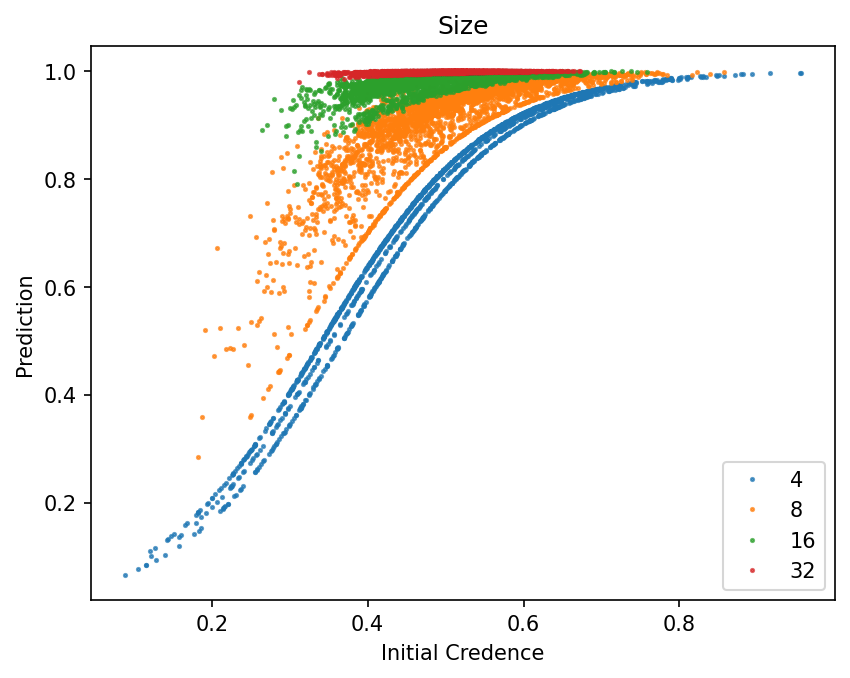

In [11]:
fig, ax = plt.subplots(dpi=150)
# plt.axhline(y=0.5, color="grey", linestyle="--", linewidth=0.5)

for name, group in sims.groupby("size"):
    plt.plot(
        group.init_credence,
        group.yhat,
        marker="o",
        linestyle="",
        markersize=1.5,
        label=name,
        alpha=0.7,
    )

plt.legend(loc="lower right")
plt.title("Size")
ax.set_xlabel("Initial Credence")
ax.set_ylabel("Prediction")

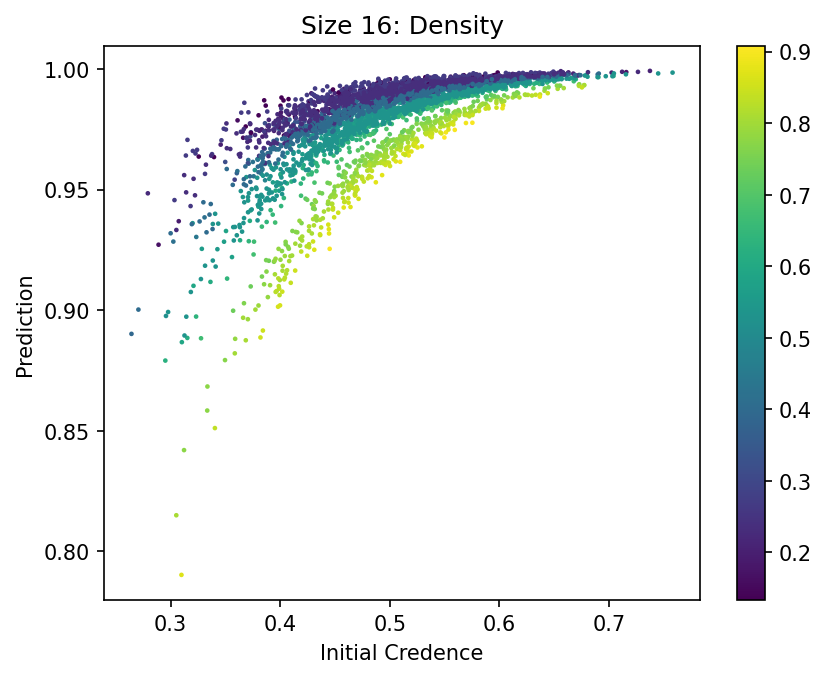

In [12]:
fig, ax = plt.subplots(dpi=150)

ax.set_xlabel("Initial Credence")
ax.set_ylabel("Prediction")
# ax.set_ylim(0, 1.1)
# ax.set_xlim(0, 1.1)

cm = plt.cm.get_cmap("viridis")

_ = sims[(sims["size"] == 16)]

sc = plt.scatter(_.init_credence, _.yhat, c=_.density, cmap=cm, s=1.5)

plt.title("Size 16: Density")
plt.colorbar(sc)
plt.show()

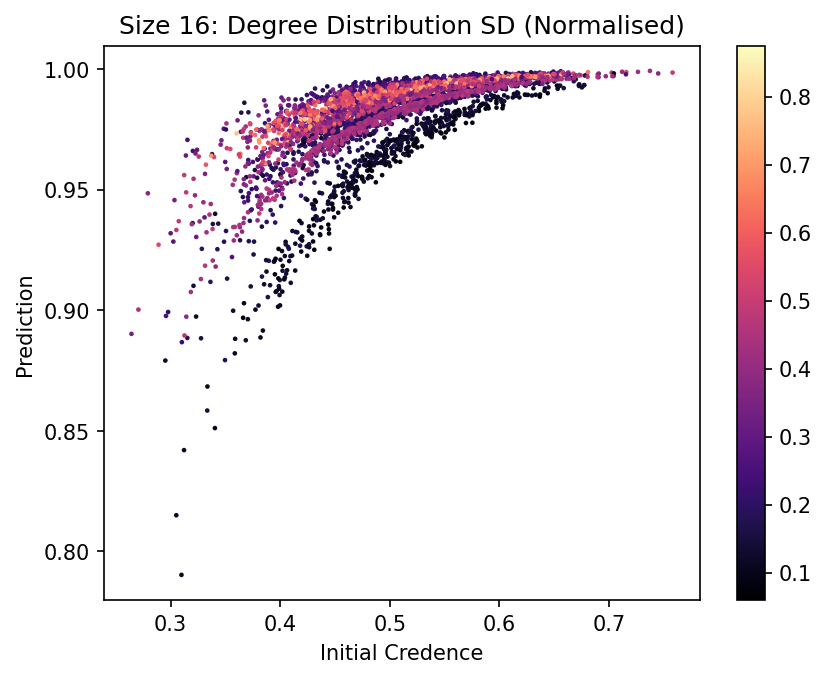

In [13]:
fig, ax = plt.subplots(dpi=150)

ax.set_xlabel("Initial Credence")
ax.set_ylabel("Prediction")
# ax.set_ylim(0, 1.1)
# ax.set_xlim(0, 1.1)

cm = plt.cm.get_cmap("magma")

_ = sims[(sims["size"] == 16)]

sc = plt.scatter(
    _.init_credence, _.yhat, c=_["moment_sd"] / _["moment_1"], cmap=cm, s=1.5
)

plt.title("Size 16: Degree Distribution SD (Normalised)")
plt.colorbar(sc)
plt.show()

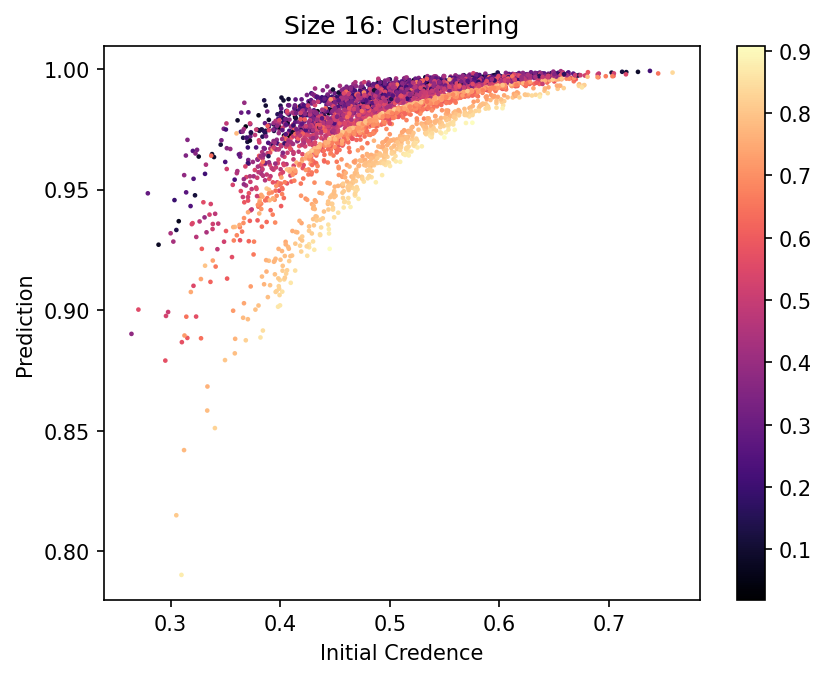

In [14]:
fig, ax = plt.subplots(dpi=150)

ax.set_xlabel("Initial Credence")
ax.set_ylabel("Prediction")
# ax.set_ylim(0, 1.1)
# ax.set_xlim(0, 1.1)

cm = plt.cm.get_cmap("magma")

_ = sims[(sims["size"] == 16)]

sc = plt.scatter(_.init_credence, _.yhat, c=_.clustering, cmap=cm, s=1.5)

plt.title("Size 16: Clustering")
plt.colorbar(sc)
plt.show()

## Prediction Lines

In [15]:
def create_predictions_df(size, density, clustering, norm_sd):
    df = pd.DataFrame(
        data={
            "const": pd.Series([1.0]).repeat(100),
            "size": pd.Series([size]).repeat(100),
            "density": pd.Series([density]).repeat(100),
            "clustering": pd.Series([clustering]).repeat(100),
            "init_credence": np.linspace(0, 1, num=100, retstep=True)[0],
            "norm_sd": pd.Series([norm_sd]).repeat(100),
        }
    )

    return df

In [16]:
line_min = pd.DataFrame()
line_median = pd.DataFrame()
line_max = pd.DataFrame()

sims["norm_sd"] = sims["moment_sd"] / sims["moment_1"]

for size in sims["size"].unique():
    # line_median
    density = sims[sims["size"] == size]["density"].mean()

    clustering = sims[sims["size"] == size]["clustering"].mean()

    norm_sd = sims[sims["size"] == size]["norm_sd"].mean()

    # Create a dataframe to predict
    _ = create_predictions_df(size, density, clustering, norm_sd)

    # Add predictions to dataframe
    _["yhat"] = logit_res.predict(_)

    # Append to results dataframe
    line_median = pd.concat([line_median, _], ignore_index=True)

    # Line Area ----------
    # Change the input into the create_predictions_df function to change the
    # line area. Currently this is set to the standard deviation around the
    # density.

    # line_min: add standard deviation to density
    min_density = density - sims[sims["size"] == size]["density"].std()
    _ = create_predictions_df(size, min_density, clustering, norm_sd)
    _["yhat"] = logit_res.predict(_)
    line_min = pd.concat([line_min, _], ignore_index=True)

    # line_max: take away standard deviation from density
    max_density = density + sims[sims["size"] == size]["density"].std()
    _ = create_predictions_df(size, max_density, clustering, norm_sd)
    _["yhat"] = logit_res.predict(_)
    line_max = pd.concat([line_max, _], ignore_index=True)

line_median.head()

,const,size,density,clustering,init_credence,norm_sd,yhat
0,1.0,32,0.379044,0.445488,0.000000,0.347437,0.873296
1,1.0,32,0.379044,0.445488,0.010101,0.347437,0.883553
2,1.0,32,0.379044,0.445488,0.020202,0.347437,0.893080
3,1.0,32,0.379044,0.445488,0.030303,0.347437,0.901915
4,1.0,32,0.379044,0.445488,0.040404,0.347437,0.910093


Text(0.5, 1.0, 'Prediction Lines')

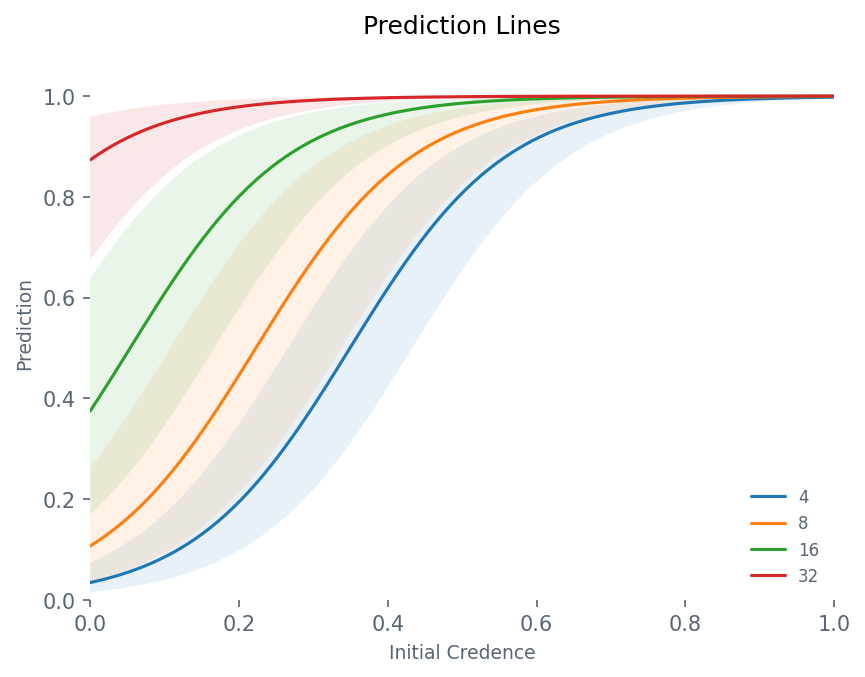

In [17]:
fig, ax = plt.subplots(dpi=150)

# for name, group in sims.groupby("size"):
#     plt.plot(
#         group.init_credence,
#         group.yhat,
#         marker="o",
#         linestyle="",
#         markersize=1.5,
#         alpha=0.04,
#     )

# plt.gca().set_prop_cycle(None)

for name, group in line_median.groupby("size"):
    ax.plot(
        group.init_credence,
        group.yhat,
        label=name,
        solid_capstyle="round",
    )

    lmin = line_min[line_min["size"] == name]["yhat"]
    lmax = line_max[line_max["size"] == name]["yhat"]
    ax.fill_between(group.init_credence, lmin, lmax, alpha=0.1)


label_colour = "#576574"
plt.legend(loc="lower right", frameon=False, fontsize=8, labelcolor=label_colour)

ax.set_xlabel("Initial Credence", color=label_colour, size=9)
ax.set_ylabel("Prediction", color=label_colour, size=9)
plt.rc("xtick", labelsize=7)
plt.rc("ytick", labelsize=7)

ax.tick_params(axis="x", colors=label_colour)
ax.tick_params(axis="y", colors=label_colour)
ax.spines["bottom"].set_color(label_colour)
ax.spines["top"].set_color(label_colour)

ax.set_ylim(0, 1.1)
ax.set_xlim(0, 1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

plt.title("Prediction Lines")

### Seperate by Size

In [18]:
def plot_sims(ax, sims, colour):
    """
    Create a scatter plot with simulations
    """
    scatter = ax.plot(
        sims.init_credence,
        sims.yhat,
        marker="o",
        linestyle="",
        markersize=0.5,
        label=name,
        alpha=0.7,
        color=colour,
    )
    return scatter

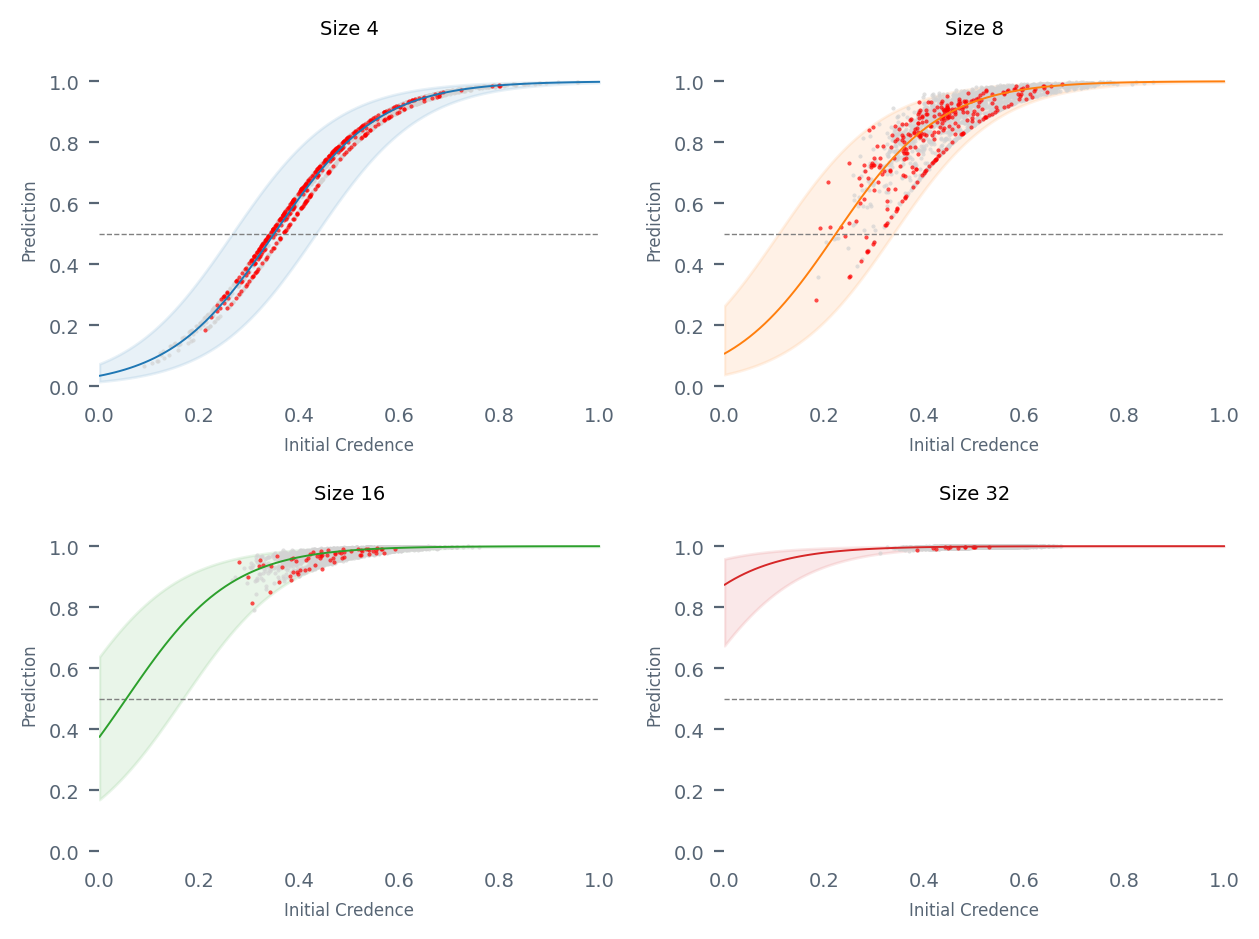

In [19]:
from itertools import cycle

# Get colour prop cycle and first colour
prop_cycle = plt.rcParams["axes.prop_cycle"]
colours = cycle(prop_cycle.by_key()["color"])
colour = next(colours)

# How many sizes of networks were there?
sizes = sorted(sims["size"].unique())

# Create and 2 column grid subplot for the number of sizes
fig, axs = plt.subplots(int(len(sizes) / 2), 2, dpi=200)

# Loop through the axes and pick the sizes in order
for i, ax in enumerate(fig.axes):
    # Prediction Area
    lmin = line_min[line_min["size"] == sizes[i]]["yhat"]
    lmax = line_max[line_max["size"] == sizes[i]]["yhat"]
    ax.fill_between(
        line_median[line_median["size"] == sizes[i]].init_credence,
        lmin,
        lmax,
        alpha=0.1,
        color=colour,
    )

    # Sims - Correct B
    correct_b_sims_data = sims[
        (sims["size"] == sizes[i]) & (sims.yhat > 0.5) & (sims.action_B == 1)
    ]
    plot_sims(ax, correct_b_sims_data, "lightgrey")

    # Sims - Correct A
    correct_a_sims_data = sims[
        (sims["size"] == sizes[i]) & (sims.yhat < 0.5) & (sims.action_B == 0)
    ]
    plot_sims(ax, correct_a_sims_data, "lightgrey")

    # Sims - Incorrect B
    incorrect_b_sims_data = sims[
        (sims["size"] == sizes[i]) & (sims.yhat < 0.5) & (sims.action_B == 1)
    ]
    plot_sims(ax, incorrect_b_sims_data, "red")

    # Sims - Incorrect A
    incorrect_a_sims_data = sims[
        (sims["size"] == sizes[i]) & (sims.yhat > 0.5) & (sims.action_B == 0)
    ]
    plot_sims(ax, incorrect_a_sims_data, "red")

    # 0.5 Line
    ax.axhline(y=0.5, color="grey", linestyle="--", linewidth=0.5)

    # Prediction Lines
    data = line_median[line_median["size"] == sizes[i]]

    ax.plot(
        data.init_credence,
        data.yhat,
        label=name,
        solid_capstyle="round",
        color=colour,
        linewidth=0.7,
    )

    # Iterate next colour for the next loop
    colour = next(colours)

    ax.set_title("Size " + str(sizes[i]), size=7)

    label_colour = "#576574"
    # plt.legend(loc="lower right", frameon=False, fontsize=6, labelcolor=label_colour)

    ax.set_xlabel("Initial Credence", color=label_colour, size=6)
    ax.set_ylabel("Prediction", color=label_colour, size=6)
    plt.rc("xtick", labelsize=5)
    plt.rc("ytick", labelsize=5)

    ax.tick_params(axis="x", colors=label_colour)
    ax.tick_params(axis="y", colors=label_colour)
    ax.spines["bottom"].set_color(label_colour)
    ax.spines["top"].set_color(label_colour)

    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 1)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("none")

plt.tight_layout()
plt.show()